# Comparison of Adjacent TMA sections

**Question:** How does the signal-to-background ratio compare across experimental replicates?

**Samples:** 
- TMA: Purchased from biomax: https://www.biomax.us/tissue-arrays/Breast/BR1506
- Adjacent Sections: BM-Her2N75-15, BM-Her2N75-17, BM-Her2N75-18 (section 16 skipped.)
- Scenes: (i.e. TMA cores) 
  - 17: ER+/HER2+, immune rich. 
  - 49: ER+/HER2+
  - 59: HER2+ immune rich

**Method**: For each stain, pixel intensity was manually thresholded to separate the positive pixels from the background. We analyze the percent positive cells based on the thresholds, the intensity of positive pixels, background pixesl, and signal-to-background ratio (SBR) or adjacent sections and different tissues on the same slide. We also automatically estimated dynamic range using the 5th and 98th percentile of single cell intensity in the tissue.

In [1]:
#load libraries
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import sys
import numpy as np
import os
from scipy.stats.stats import pearsonr
import itertools
from scipy import stats
matplotlib.rcParams.update({'font.size': 20})
import seaborn as sns


## Load Data

In [2]:
#set location of files
#os.chdir('/home/groups/graylab_share/OMERO.rdsStore/engje/Data/cycIF_ValidationStudies/cycIF_Validation/')
codedir =  os.getcwd()

In [3]:
#load threshold, SNR data

d_rename = {'Her2':'HER2','LaminAC':'LamAC','pH3':'pHH3'}
df_t = pd.read_csv(f'{codedir}/Metadata/BM-Her2N75/SNR_jenny_replicates.csv',index_col=0)
df_t.marker = df_t.marker.replace(to_replace=d_rename)
df_t['scene'] = [item.split('Scene-0')[1] for item in df_t.scene]
#load metadata from feature extraction
df_m = pd.read_csv(f'{codedir}/Metadata/BM-Her2N75/metadata_JennyReps.csv',index_col=0)

In [4]:
#calculate actual signal (ie measure signal minus background)
df_t['meanpos'] = df_t.meanpos - df_t.meanneg

# import mean int

In [5]:
#import dataframes with mean intensity
df_mi =pd.DataFrame()
     
ls_sample =  ['BM-Her2N75-15','BM-Her2N75-17','BM-Her2N75-18']

for s_sample in ls_sample:
    df_tt = pd.read_csv(f'{codedir}/Data/features_{s_sample}-3S_MeanIntensity.csv',index_col=0)
    df_mi = df_mi.append(df_tt)
#add the slide/scene information 

df_mi['slide'] = [item.split('_')[0] for item in df_mi.index]
df_mi.drop('_Nuclei',axis=1,inplace=True)

In [6]:
df_mi['slide_scene'] = df_mi.slide + '_' + df_mi.scene

In [10]:
if not os.path.exists(f'{codedir}/Data/20201229_BM-Her2N75-15-17-18_MeanIntensity.csv'):
    print('saving')
    df_mi[~df_mi.index.str.contains('cell00000')].to_csv(f'{codedir}/Data/20201229_BM-Her2N75-15-17-18_MeanIntensity.csv')

In [14]:
#output sampled data for normalization and kBET evaluation
#select 1000 rand cells for each scene in ls_scene
filterdir = '/home/groups/graylab_share/OMERO.rdsStore/engje/Data/20201105_SMT101/filtered_data'
i_rand = 9
df_sample = pd.DataFrame()
for s_scene in sorted(set(df_mi.slide_scene)):
    df_scene = df_mi[df_mi.slide_scene==s_scene]
    df_sample = df_sample.append(df_scene.sample(n=600,  replace=False,  random_state=i_rand)) #7, 8, 9 (2)
df_sample = df_sample.loc[:,df_sample.dtypes=='float64']
df_sample['batch'] = [item.split('_')[0] for item in df_sample.index]
if not os.path.exists(f'{codedir}/Data/20201229_BM-Her2N75-15-17-18_MeanIntensity.csv'):
    print('saving')
    np.log2(df_sample.loc[:,df_sample.dtypes=='float64']+1).to_csv(f'{filterdir}/2020120{i_rand}_BM-Her2N75_SampledMeanIntensity_log2.csv')
    (df_sample.loc[:,df_sample.dtypes=='float64']).to_csv(f'{filterdir}/2020120{i_rand}_BM-Her2N75_SampledMeanIntensity_raw.csv')

# Dynamic Range

In [54]:
#calculate 5th and 98th percentile to estimate dynamic range
i_high_quantile = 0.98
i_high_quantile = 0.999
df_result = pd.DataFrame()
for s_slide in ['BM-Her2N75-15', 'BM-Her2N75-17', 'BM-Her2N75-18']:
    for s_scene in ['scene017', 'scene049', 'scene059']:
        for s_marker in df_mi.columns[df_mi.dtypes=='float64']:
            se_feat = df_mi.loc[((df_mi.slide==s_slide) & (df_mi.scene==s_scene)),s_marker]
            s_index = f'{s_slide}_{s_scene}_{s_marker}'
            df_result.loc[s_index,'low05'] = se_feat.quantile(0.05)
            df_result.loc[s_index,'high95'] = se_feat.quantile(i_high_quantile)
            df_result.loc[s_index,'slide'] = s_slide
            df_result.loc[s_index,'core'] = s_scene
            df_result.loc[s_index,'marker'] = s_marker.split('_')[0]
df_result['dynamic_range'] = df_result.high95 - df_result.low05
df_result['estimated_SBR'] = (df_result.high95- df_result.low05)/df_result.low05


# histograms: manual vs estimated

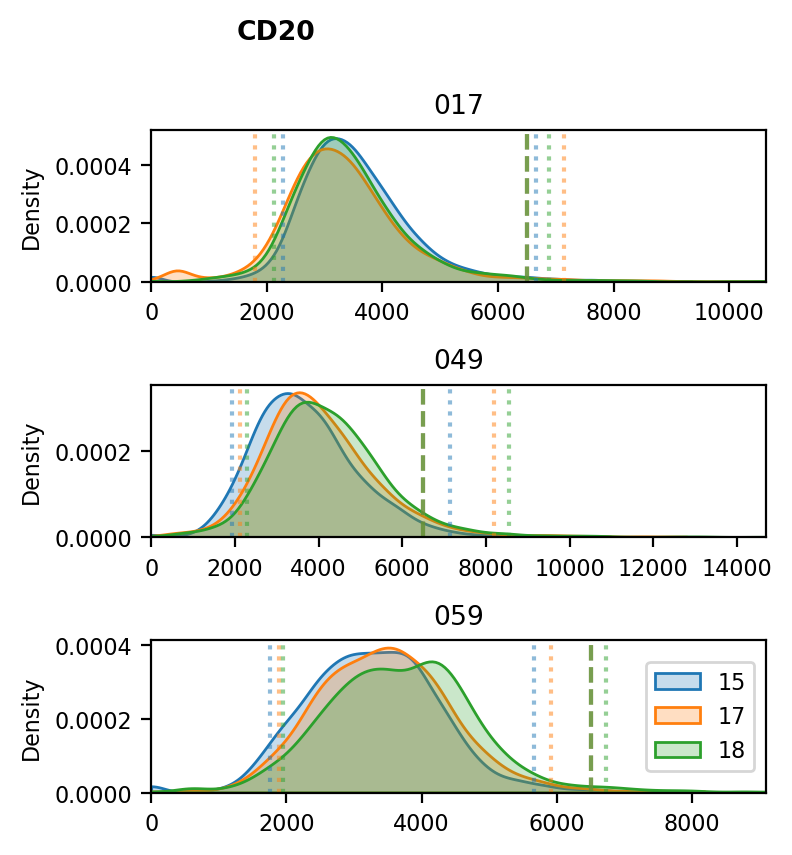

In [21]:
#use the histograms
matplotlib.rcParams.update({'font.size': 8})
for s_marker in df_mi.columns[df_mi.dtypes=='float64']:
    fig,ax = plt.subplots(3,1,figsize=(4,4.2),dpi=200)
    for idxs, s_scene in enumerate(sorted(set(df_mi.scene))):
        df_scene = df_mi[df_mi.scene==s_scene]
        for idx, s_slide in enumerate(sorted(set(df_mi.slide))): 
            se_slide = df_scene[df_scene.slide==s_slide].loc[:,s_marker]
            se_slide.name = f"{s_slide.split('-')[-1]}"
            i_max = np.quantile(se_slide,.995)
            sns.kdeplot(se_slide,shade=True,ax=ax[idxs],clip=(0,i_max),label=f"{s_slide.split('-')[-1]}")    
            i_high = np.quantile(se_slide,.98)
            i_mid = np.quantile(se_slide,.465)
            i_low = np.quantile(se_slide,.05)
            i_manual = df_t[(df_t.slide==s_slide) & (df_t.scene==s_scene.split('scene0')[1])& (df_t.marker==s_marker.split('_')[0])].minimum[0]
            ax[idxs].axvline(i_high, c=f'C{idx}', alpha=0.5,ls=':')
            ax[idxs].axvline(i_low, c=f'C{idx}', alpha=0.5,ls=':')
            ax[idxs].axvline(i_manual, c=f'C{idx}',alpha=0.5,ls='--')
        ax[idxs].set_xlim(left=0,right=i_max)
        ax[idxs].set_xlabel('')
        ax[idxs].set_title(s_scene.split('scene')[1])
        #ax[idxs].get_legend().remove()
    ax[idxs].legend(loc='right')
    plt.suptitle(s_marker.split('_')[0],x=.35,y=1,weight='bold')
    plt.tight_layout()
    fig.savefig(f'{codedir}/Figures/TMArepeats_{s_marker}_kde.png')
    break
    if s_marker != 'HER2_Ring':
        plt.close()


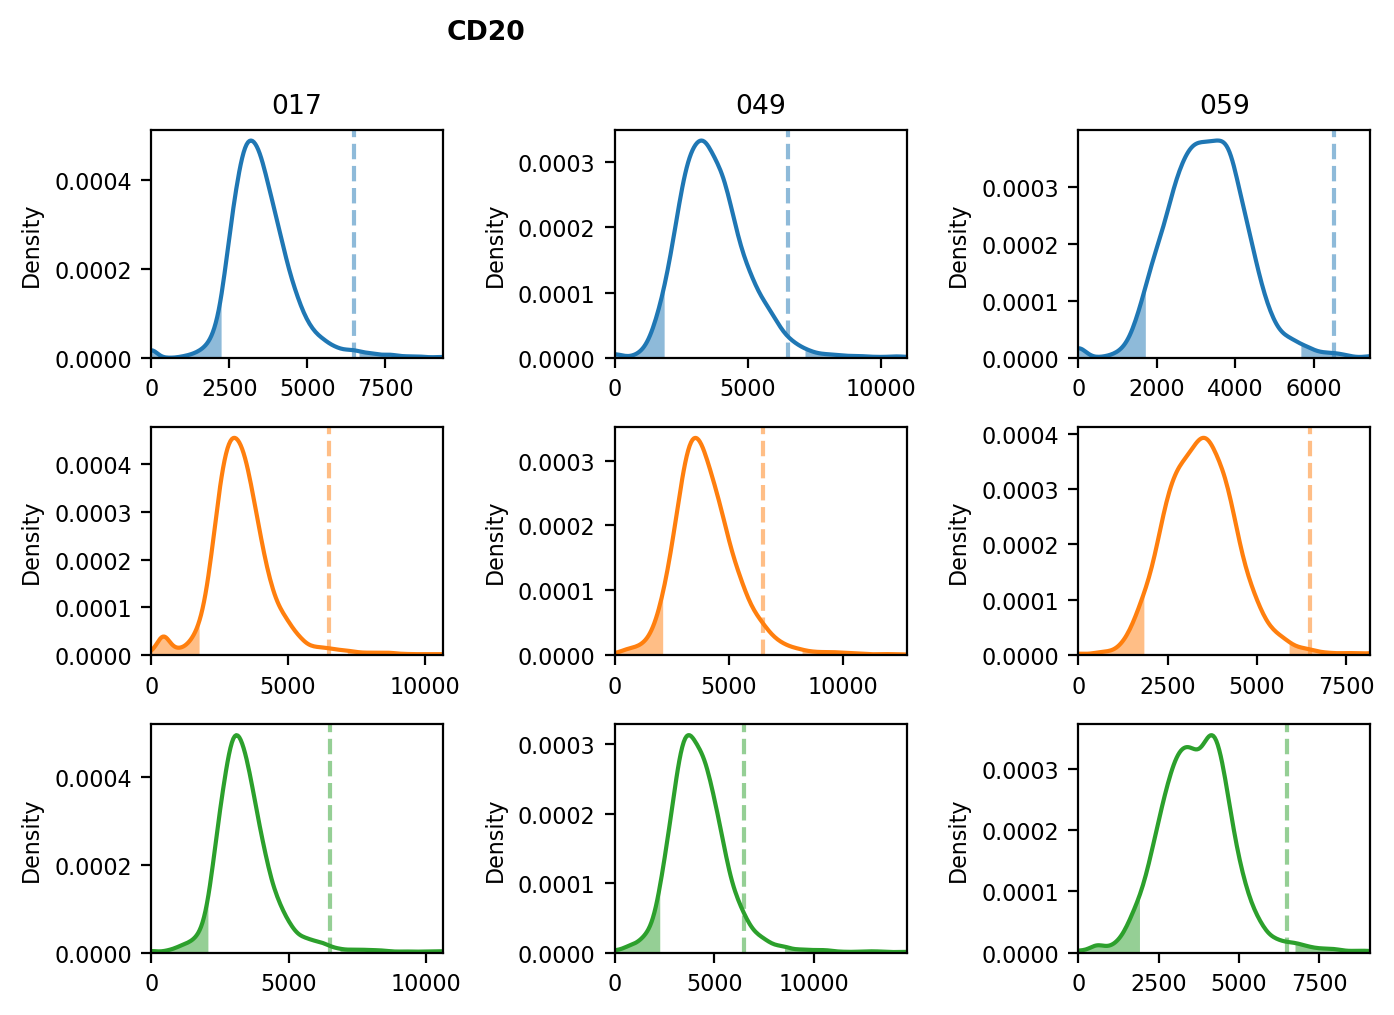

In [22]:
#shaded histograms
hatch=['', '-', '|']
matplotlib.rcParams.update({'font.size': 8})
for s_marker in df_mi.columns[df_mi.dtypes=='float64']:
    fig,ax = plt.subplots(3,3,figsize=(7,5),dpi=200)
    for idxs, s_scene in enumerate(sorted(set(df_mi.scene))):
        df_scene = df_mi[df_mi.scene==s_scene]
        for idx, s_slide in enumerate(sorted(set(df_mi.slide))): 
            se_slide = df_scene[df_scene.slide==s_slide].loc[:,s_marker]
            se_slide.name = f"{s_slide.split('-')[-1]}"
            i_max = np.quantile(se_slide,.995)
            a_sing = sns.kdeplot(se_slide,shade=False,ax=ax[idx,idxs],clip=(0,i_max),color=f'C{idx}',label=f"{s_slide.split('-')[-1]}").get_lines()[0].get_data()
            i_high = np.quantile(se_slide,i_high_quantile)
            i_low = np.quantile(se_slide,.05)
            ax[idx,idxs].fill_between(x=a_sing[0], y1=a_sing[1], y2=0,where=a_sing[0] > i_high,facecolor=f'C{idx}',alpha=0.5)
            ax[idx,idxs].fill_between(x=a_sing[0], y1=a_sing[1], y2=0,where=a_sing[0] < i_low,facecolor=f'C{idx}',alpha=0.5)
            i_manual = df_t[(df_t.slide==s_slide) & (df_t.scene==s_scene.split('scene0')[1])& (df_t.marker==s_marker.split('_')[0])].minimum[0]
            ax[idx,idxs].axvline(i_manual, c=f'C{idx}',alpha=0.5,ls='--')
            ax[idx,idxs].set_xlim(left=0,right=i_max)
            ax[idx,idxs].set_xlabel('')
        ax[0,idxs].set_title(s_scene.split('scene')[1])
    plt.suptitle(s_marker.split('_')[0],x=.35,y=1,weight='bold')
    plt.tight_layout()
    fig.savefig(f'{codedir}/Figures/TMArepeats_shaded_{s_marker}_kde.png')
    break
    if s_marker != 'HER2_Ring':
        plt.close()

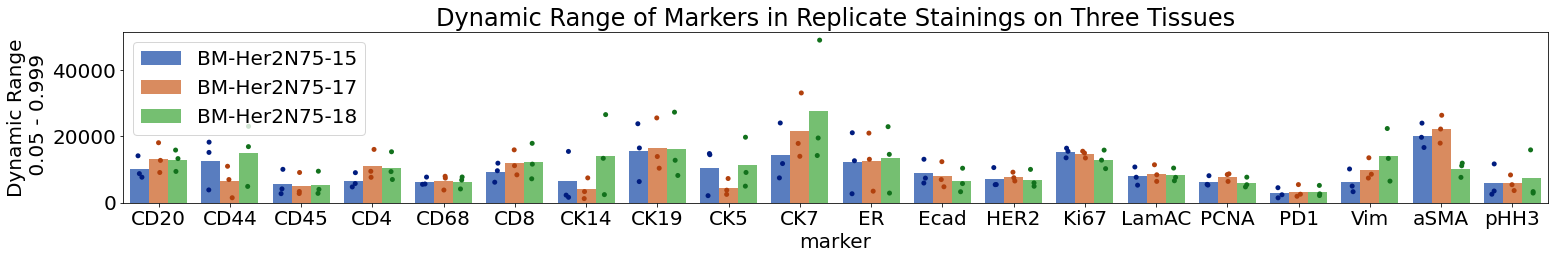

In [55]:
fig,ax = plt.subplots(figsize=(22,4))
sns.barplot(x="marker", y="dynamic_range", hue="slide", data=df_result, ax=ax,palette='muted',ci=None)
h, l = ax.get_legend_handles_labels()
sns.stripplot(x="marker", y="dynamic_range", hue="slide", data=df_result,dodge=True, ax=ax,palette='dark')
ax.legend(h,l)
ax.set_title('Dynamic Range of Markers in Replicate Stainings on Three Tissues')
s_ylabel = f'Dynamic Range\n 0.05 - {i_high_quantile}'
ax.set_ylabel(s_ylabel)
s_figname =f'{codedir}/Figures/Dynamic_Range_all_markers_TMAs_{i_high_quantile}.png'
plt.tight_layout()
fig.savefig(s_figname)

In [32]:
df_15 = df_result[df_result.slide=='BM-Her2N75-15']
df_15.index = [item.split('scene')[1] for item in df_15.index]
df_17 = df_result[df_result.slide=='BM-Her2N75-17']
df_17.index = [item.split('scene')[1] for item in df_17.index]
df_18 = df_result[df_result.slide=='BM-Her2N75-18']
df_18.index = [item.split('scene')[1] for item in df_18.index]

df1 = df_15.loc[:,df_15.dtypes=='float64']/df_17.loc[:,df_17.dtypes=='float64']
df2 = df_17.loc[:,df_17.dtypes=='float64']/df_18.loc[:,df_18.dtypes=='float64']
df3 = df_18.loc[:,df_18.dtypes=='float64']/df_15.loc[:,df_15.dtypes=='float64']


In [33]:
df_long = pd.DataFrame()
df_long = df_long.append(df1)
df_long = df_long.append(df2)
df_long = df_long.append(df3)
df_long['marker'] = [item.split('_')[1] for item in df_long.index]
df_long['core'] = [item.split('_')[0] for item in df_long.index]

In [34]:
df_long.sort_values('marker',inplace=True)

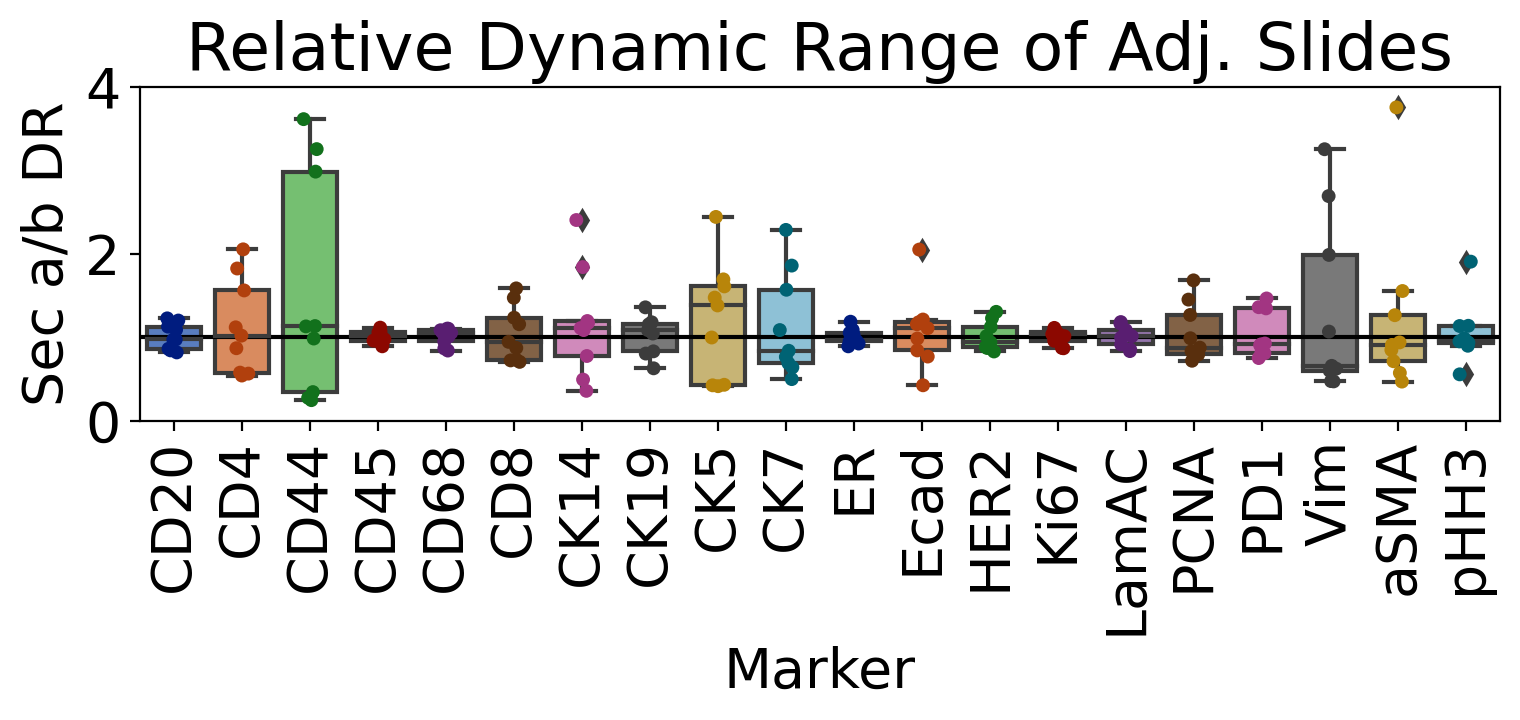

In [44]:
#dynamic range
matplotlib.rcParams.update({'font.size': 20})
s_title = 'Relative Dynamic Range of Adj. Slides'
s_ylabel = 'Sec a/b DR'
s_figname =f'{codedir}/Figures/Dynamic_Range_mean_Ratio_TMAs_{i_high_quantile}.png'
fig, ax = plt.subplots(figsize=(8,4),dpi=200)
sns.boxplot(data=df_long, x='marker', y='dynamic_range', palette = 'muted')
sns.stripplot(data=df_long, x='marker', y='dynamic_range', palette = 'dark')
ax.set_ylabel(s_ylabel)
ax.set_ylim(0,4)
ax.set_xlabel("Marker")
ax.axhline(1,color='black')

labels=ax.get_xticklabels()
ax.set_xticklabels(labels, rotation=90)
ax.set_title(s_title)

plt.tight_layout()
fig.savefig(s_figname)

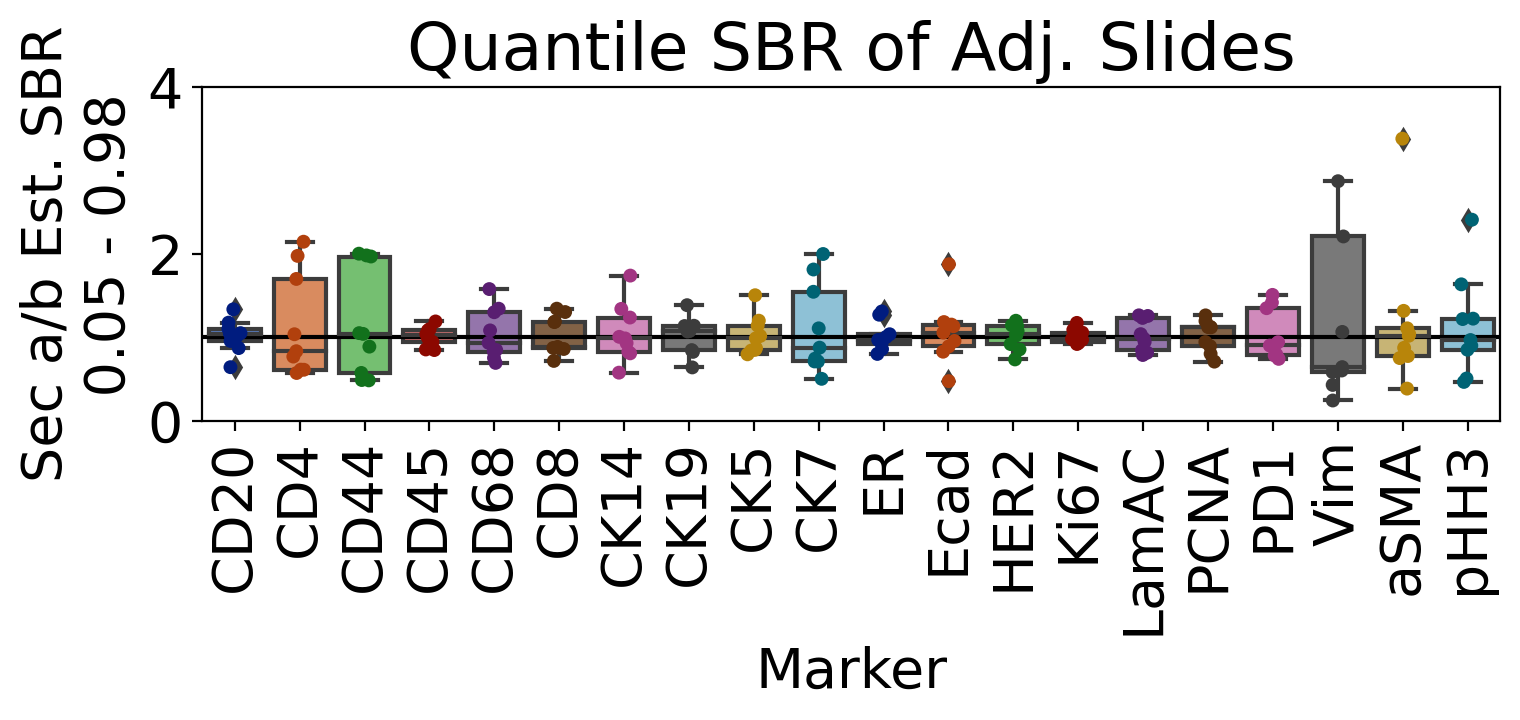

In [48]:
#barplot of mean
s_title = 'Quantile SBR of Adj. Slides'
s_ylabel = f'Sec a/b Est. SBR\n 0.05 - {i_high_quantile}'
s_figname =f'{codedir}/Figures/Estimated_SBR_mean_Ratio_TMAs_{i_high_quantile}.png'
fig, ax = plt.subplots(figsize=(8,4),dpi=200)
sns.boxplot(data=df_long, x='marker', y='estimated_SBR', palette = 'muted')
sns.stripplot(data=df_long, x='marker', y='estimated_SBR', palette = 'dark')
ax.set_ylabel(s_ylabel)
ax.set_ylim(0,4)
ax.set_xlabel("Marker")
ax.axhline(1,color='black')

labels=ax.get_xticklabels()
ax.set_xticklabels(labels, rotation=90)
ax.set_title(s_title)

plt.tight_layout()
fig.savefig(s_figname)

# Percent Positive

Thresholds were set on the images, using the pattern of staining to set an intensity value above which pixels were considered positive for a stain.

Here, the same theresholds are applied to the single cell mean intensity values. If a cell has a mean intensity above the pixel threshold, it is considered positive. Percent of positive cells over all segmented cells is calculated for each marker.

In [34]:
#calculate positive cells based on thresholding the mean intensity dataframe

#empty dataframe
df_pos = pd.DataFrame()
df_pos_cell = pd.DataFrame(index=df_mi.index)
#for each sample
for s_index in df_t.index:
    s_tissue = df_t.loc[s_index,'slide']
    s_marker = df_t.loc[s_index,'marker']
    s_scene = df_t.loc[s_index,'scene']
    df_m_slide = df_m[(df_m.slide==s_tissue) & (df_m.marker == s_marker)]
    if len(df_m_slide) !=1:
        print(df_m_slide)
    #when the features were extracted we had some exposure normalization ... need to undo
    i_thresh = df_t.loc[s_index,'threshold']/(df_m_slide.loc[:,'refexp']/df_m_slide.loc[:,'exposure'])
    s_marker_loc = df_mi.columns[pd.Series([item.split('_')[0]==s_marker for item in df_mi.columns])][0]
    df_slide = df_mi[(df_mi.slide==s_tissue)& (df_mi.scene==f'scene0{s_scene}')]
    df_pos.loc[s_marker,f'{s_tissue}_s{s_scene}'] = ((df_mi[(df_mi.slide==s_tissue)& (df_mi.scene==f'scene0{s_scene}')].loc[:,s_marker_loc] > i_thresh[0]).sum())/len(df_mi[(df_mi.slide==s_tissue)& (df_mi.scene==f'scene0{s_scene}')])
    df_pos_cell.loc[df_slide.index,s_marker_loc] = (df_slide.loc[:,s_marker_loc] > i_thresh[0])

In [35]:
#generate plotting dataframe
#percent pos
df_percent = pd.DataFrame()
df_15 = df_pos.loc[:,df_pos.columns[df_pos.columns.str.contains('N75-15')]]
df_15.columns = [item.split('_s')[1] for item in df_15.columns]
df_17 = df_pos.loc[:,df_pos.columns[df_pos.columns.str.contains('N75-17')]]
df_17.columns = [item.split('_s')[1] for item in df_17.columns]
df_18 = df_pos.loc[:,df_pos.columns[df_pos.columns.str.contains('N75-18')]]
df_18.columns = [item.split('_s')[1] for item in df_18.columns]

df1 = df_15/df_17
df2 = df_17/df_18
df3 = df_18/df_15

df_long = pd.DataFrame()
df_longer = pd.DataFrame()
df_long = df_long.append(df1)
df_long = df_long.append(df2)
df_long = df_long.append(df3)
for s_marker in df1.index:
    se_app = df_long.T.unstack()[s_marker]
    se_app.name = 'value'
    df_app = pd.DataFrame(se_app)
    df_app['marker'] = s_marker
    df_longer = df_longer.append(df_app)
#stats
print(df_long.mean(axis=1).mean())
print(df_long.mean(axis=1).std())

1.103292888133031
0.3897180653362968


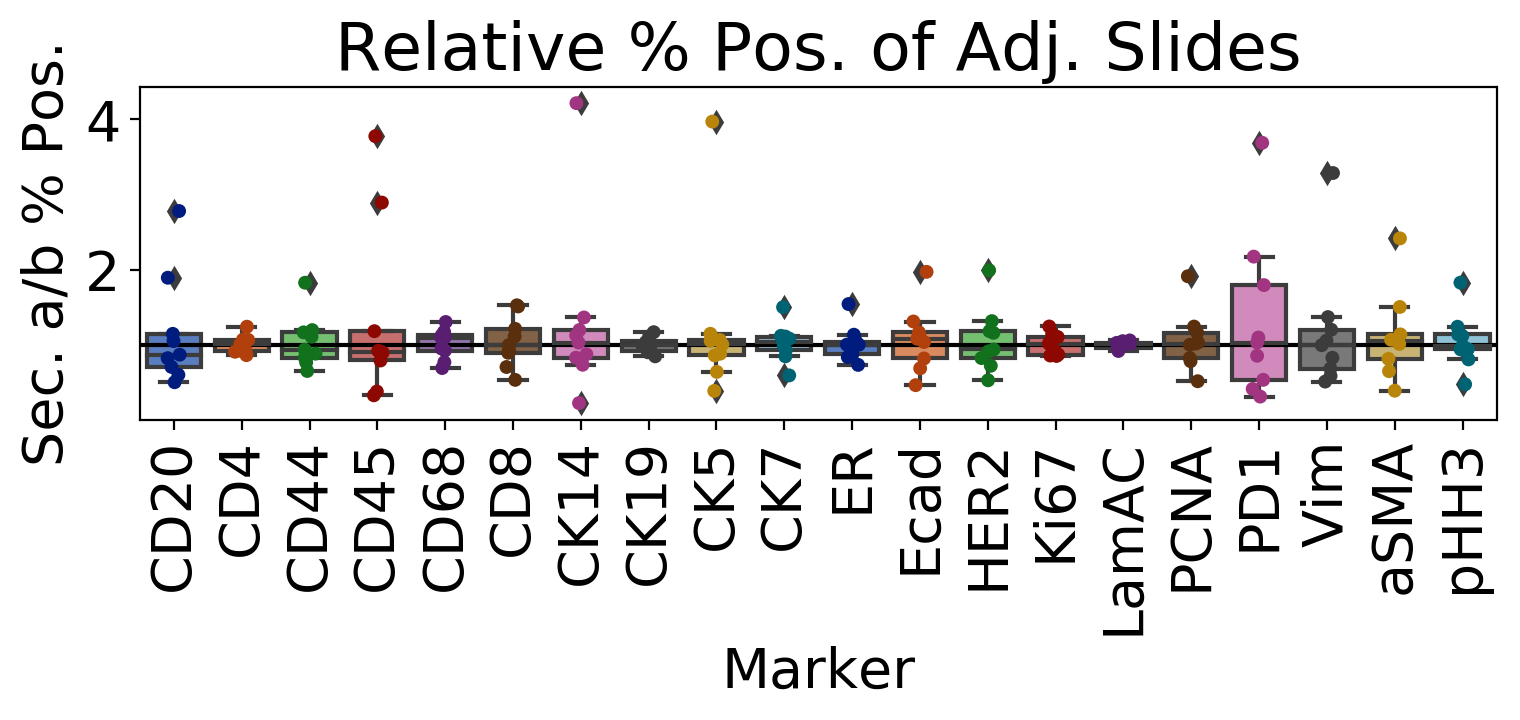

In [36]:
#boxplot
s_title = "Relative % Pos. of Adj. Slides"
s_ylabel = "Sec. a/b % Pos."
s_figname =f'{codedir}/Figures/BM-Her2N75/Percent_Positive_JennyReps_boxplot.png'
fig, ax = plt.subplots(figsize=(8,4),dpi=200)
sns.boxplot(data=df_longer, x='marker', y='value', palette = 'muted')
sns.stripplot(data=df_longer, x='marker', y='value', palette = 'dark')
ax.set_ylabel(s_ylabel)
#ax.set_ylim(0,4.1)
ax.set_xlabel("Marker")
ax.axhline(1,color='black')

labels=ax.get_xticklabels()
ax.set_xticklabels(labels, rotation=90)
ax.set_title(s_title)

plt.tight_layout()
fig.savefig(s_figname)

# mean intensity 

The mean intensity of pixels above the threshold

In [37]:
#mean intensity
df_percent = pd.DataFrame()
df_15 = ((df_t[df_t.slide=='BM-Her2N75-15']).groupby(['marker','scene']).meanpos.mean())
df_17 = ((df_t[df_t.slide=='BM-Her2N75-17']).groupby(['marker','scene']).meanpos.mean())
df_18 = ((df_t[df_t.slide=='BM-Her2N75-18']).groupby(['marker','scene']).meanpos.mean())

df1 = df_15.unstack()/df_17.unstack()
df2 = df_17.unstack()/df_18.unstack()
df3 = df_18.unstack()/df_15.unstack()

df_long = pd.DataFrame()
df_longer = pd.DataFrame()
df_long = df_long.append(df1)
df_long = df_long.append(df2)
df_long = df_long.append(df3)
for s_marker in df1.index:
    ls_app = df_long.loc[s_marker].unstack().values
    df_app = pd.DataFrame(ls_app,columns=['value'])
    df_app['marker'] = s_marker
    df_longer = df_longer.append(df_app)
#stats
print(df_long.mean(axis=1).mean())
print(df_long.mean(axis=1).std())

1.11834460932029
0.6259852434704575


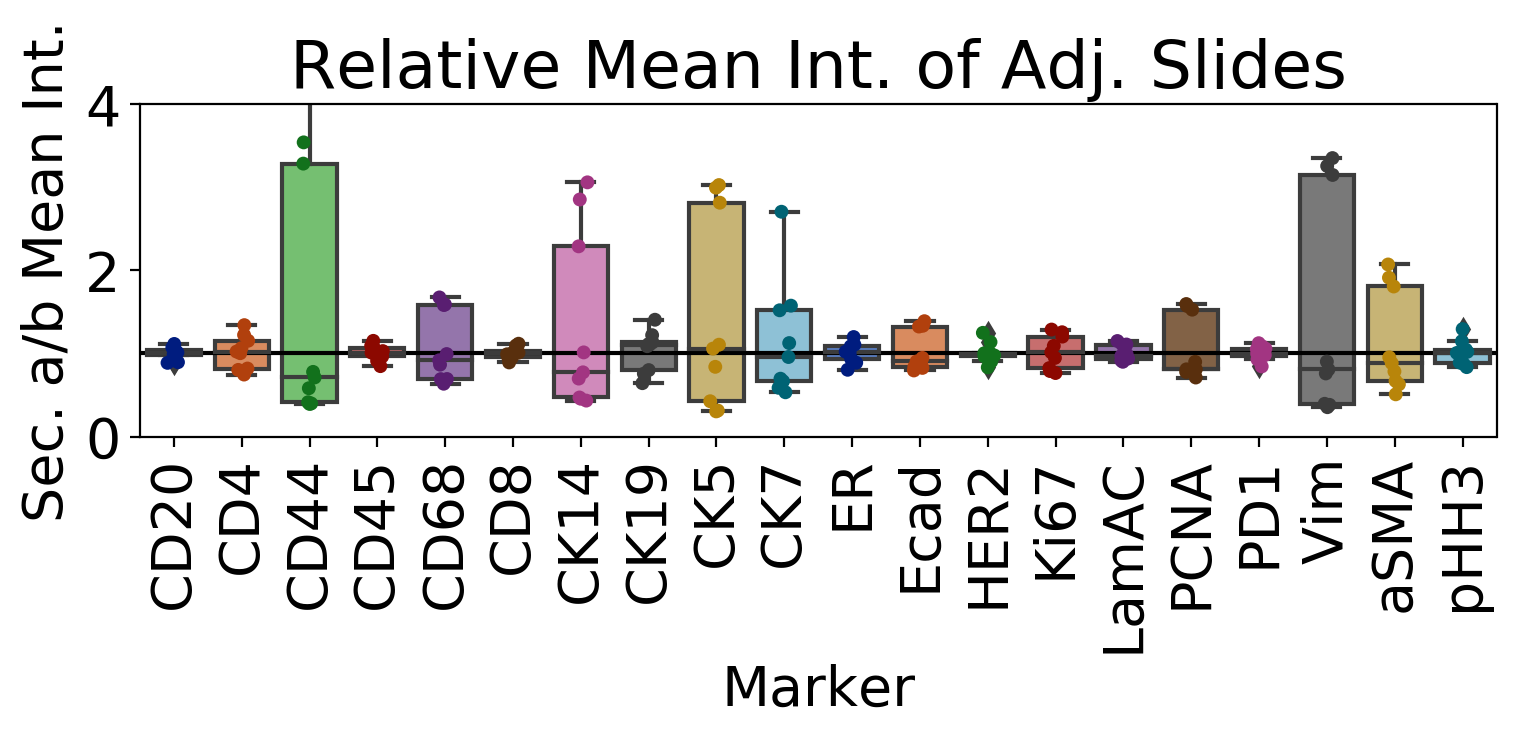

In [38]:
#boxplot

s_title = "Relative Mean Int. of Adj. Slides"
s_ylabel = "Sec. a/b Mean Int."

s_figname = f'{codedir}/Figures/BM-Her2N75/Mean_Intensity_Ratio_JennyReps_boxplot.png'

fig, ax = plt.subplots(figsize=(8,4),dpi=200)
#df_plot = df_percent.sort_values('mean_ratio', ascending=False).loc[:,['mean_ratio','stand_dev']]
#df_plot.plot(kind='bar', yerr='stand_dev', ax=ax, title = s_title,legend=False)
sns.boxplot(data=df_longer, x='marker', y='value', palette = 'muted')
sns.stripplot(data=df_longer, x='marker', y='value', palette = 'dark')
ax.set_ylabel(s_ylabel)
ax.set_ylim(0,4)
ax.set_xlabel("Marker")
ax.axhline(1,color='black')

labels=ax.get_xticklabels()
ax.set_xticklabels(labels, rotation=90)
ax.set_title(s_title)


plt.tight_layout()
fig.savefig(s_figname)

# background

The mean intensity of pixels below the threshold

In [39]:
#background

#mean intensity
df_percent = pd.DataFrame()
df_15 = ((df_t[df_t.slide=='BM-Her2N75-15']).groupby(['marker','scene']).meanneg.mean())
df_17 = ((df_t[df_t.slide=='BM-Her2N75-17']).groupby(['marker','scene']).meanneg.mean())
df_18 = ((df_t[df_t.slide=='BM-Her2N75-18']).groupby(['marker','scene']).meanneg.mean())

df1 = df_15.unstack()/df_17.unstack()
df2 = df_17.unstack()/df_18.unstack()
df3 = df_18.unstack()/df_15.unstack()

df_long = pd.DataFrame()
df_longer = pd.DataFrame()
df_long = df_long.append(df1)
df_long = df_long.append(df2)
df_long = df_long.append(df3)
for s_marker in df1.index:
    ls_app = df_long.loc[s_marker].unstack().values
    df_app = pd.DataFrame(ls_app,columns=['value'])
    df_app['marker'] = s_marker
    df_longer = df_longer.append(df_app)
#stats
print(df_long.mean(axis=1).mean())
print(df_long.mean(axis=1).std())

1.0542918048348704
0.3714688657979955


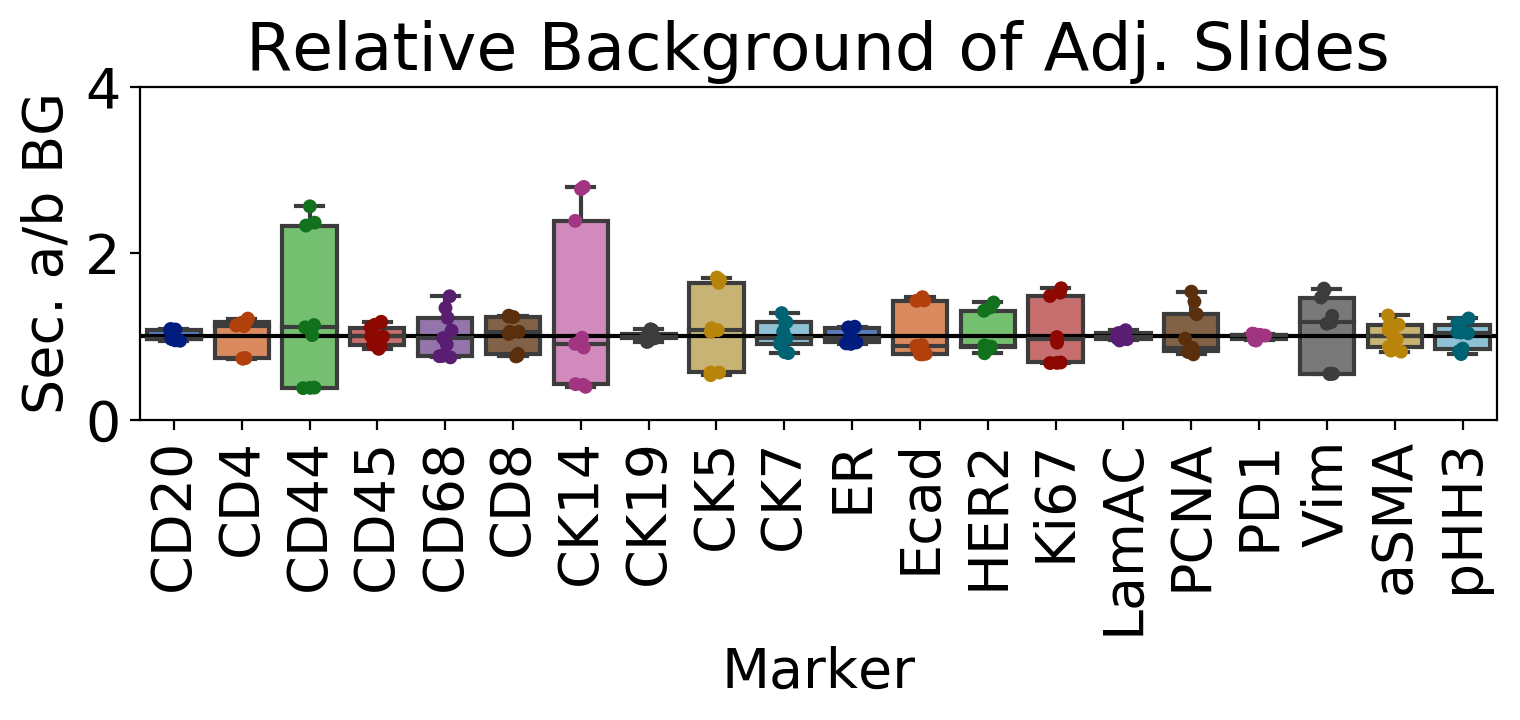

In [40]:
#yay
s_title = "Relative Background of Adj. Slides"
s_ylabel = "Sec. a/b BG"

s_figname =f'{codedir}/Figures/BM-Her2N75/Background_Noise_Ratio_JennyReps_boxplot.png'

fig, ax = plt.subplots(figsize=(8,4),dpi=200)
sns.boxplot(data=df_longer, x='marker', y='value', palette = 'muted')
sns.stripplot(data=df_longer, x='marker', y='value', palette = 'dark')
ax.set_ylabel(s_ylabel)
ax.set_ylim(0,4)
ax.set_xlabel("Marker")
ax.axhline(1,color='black')

labels=ax.get_xticklabels()
ax.set_xticklabels(labels, rotation=90)
ax.set_title(s_title)


plt.tight_layout()
fig.savefig(s_figname)

# Signal to Background Ratio

SBR = mean intensity above threshold/mean intensity below threshold

compare SBR of rep1 relative to 2, rep2 to 3 and rep3 to 1

three tissues analyzed per TMA (so total n=9)

In [41]:
df_t['SNR'] = df_t.meanpos/df_t.meanneg

In [42]:
#generate plotting dataframe
df_percent = pd.DataFrame()
df_15 = ((df_t[df_t.slide=='BM-Her2N75-15']).groupby(['marker','scene']).SNR.mean())
df_17 = ((df_t[df_t.slide=='BM-Her2N75-17']).groupby(['marker','scene']).SNR.mean())
df_18 = ((df_t[df_t.slide=='BM-Her2N75-18']).groupby(['marker','scene']).SNR.mean())

df1 = df_15.unstack()/df_17.unstack()
df2 = df_17.unstack()/df_18.unstack()
df3 = df_18.unstack()/df_15.unstack()

df_long = pd.DataFrame()
df_longer = pd.DataFrame()
df_long = df_long.append(df1)
df_long = df_long.append(df2)
df_long = df_long.append(df3)
for s_marker in df1.index:
    ls_app = df_long.loc[s_marker].unstack().values
    df_app = pd.DataFrame(ls_app,columns=['value'])
    df_app['marker'] = s_marker
    df_longer = df_longer.append(df_app)
#stats
print(df_long.mean(axis=1).mean())
print(df_long.mean(axis=1).std())

1.0414212583481581
0.2980707716122241


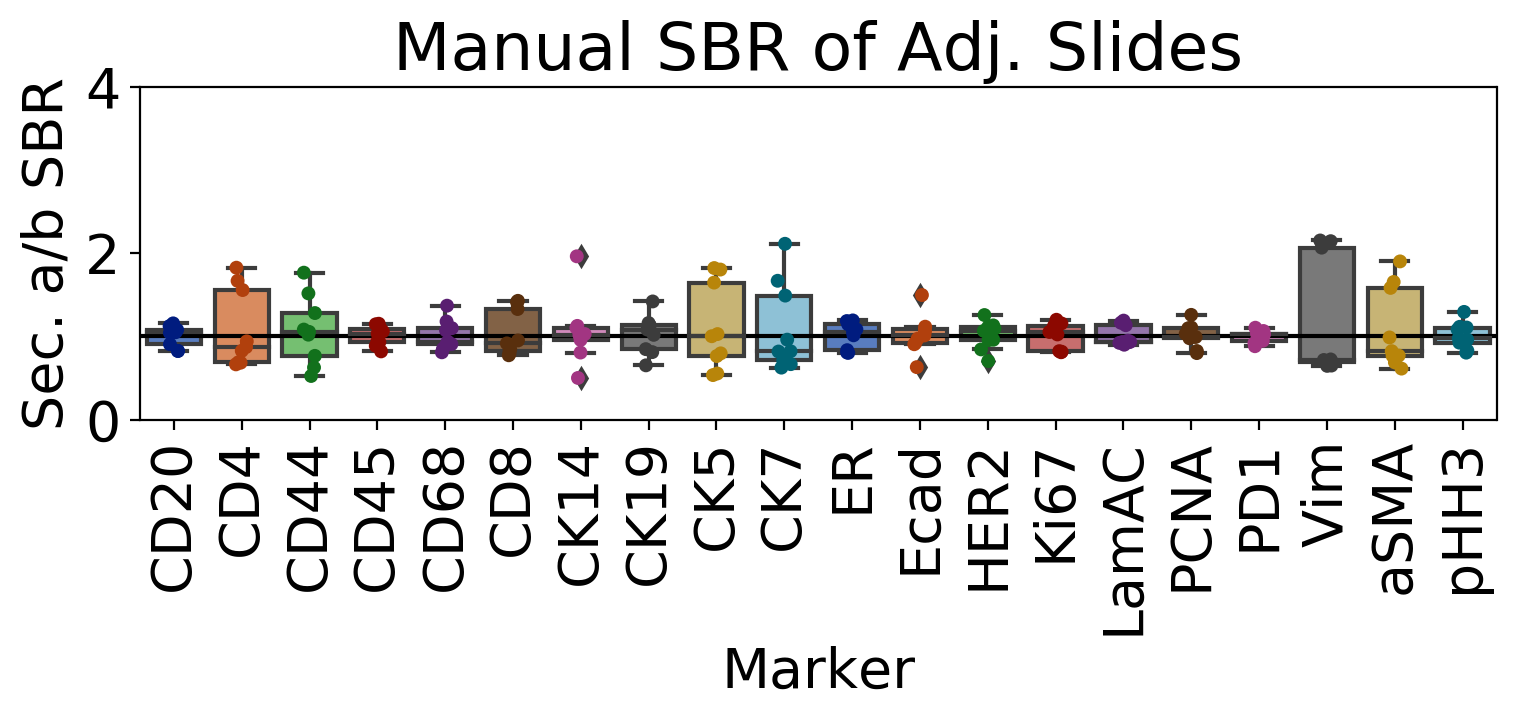

In [43]:

s_title = "Manual SBR of Adj. Slides"
s_ylabel = "Sec. a/b SBR"

s_figname =f'{codedir}/Figures/BM-Her2N75/SNR_Ratio_JennyReps__boxplot.png'
fig, ax = plt.subplots(figsize=(8,4),dpi=200)
#df_plot = df_percent.sort_values('mean_ratio', ascending=False).loc[:,['mean_ratio','stand_dev']]
#df_plot.plot(kind='bar', yerr='stand_dev', ax=ax, title = s_title,legend=False)
sns.boxplot(data=df_longer, x='marker', y='value', palette = 'muted')
sns.stripplot(data=df_longer, x='marker', y='value', palette = 'dark')
ax.set_ylabel(s_ylabel)
ax.set_ylim(0,4)
ax.set_xlabel("Marker")
ax.axhline(1,color='black')

labels=ax.get_xticklabels()
ax.set_xticklabels(labels, rotation=90)
ax.set_title(s_title)


plt.tight_layout()
fig.savefig(s_figname)

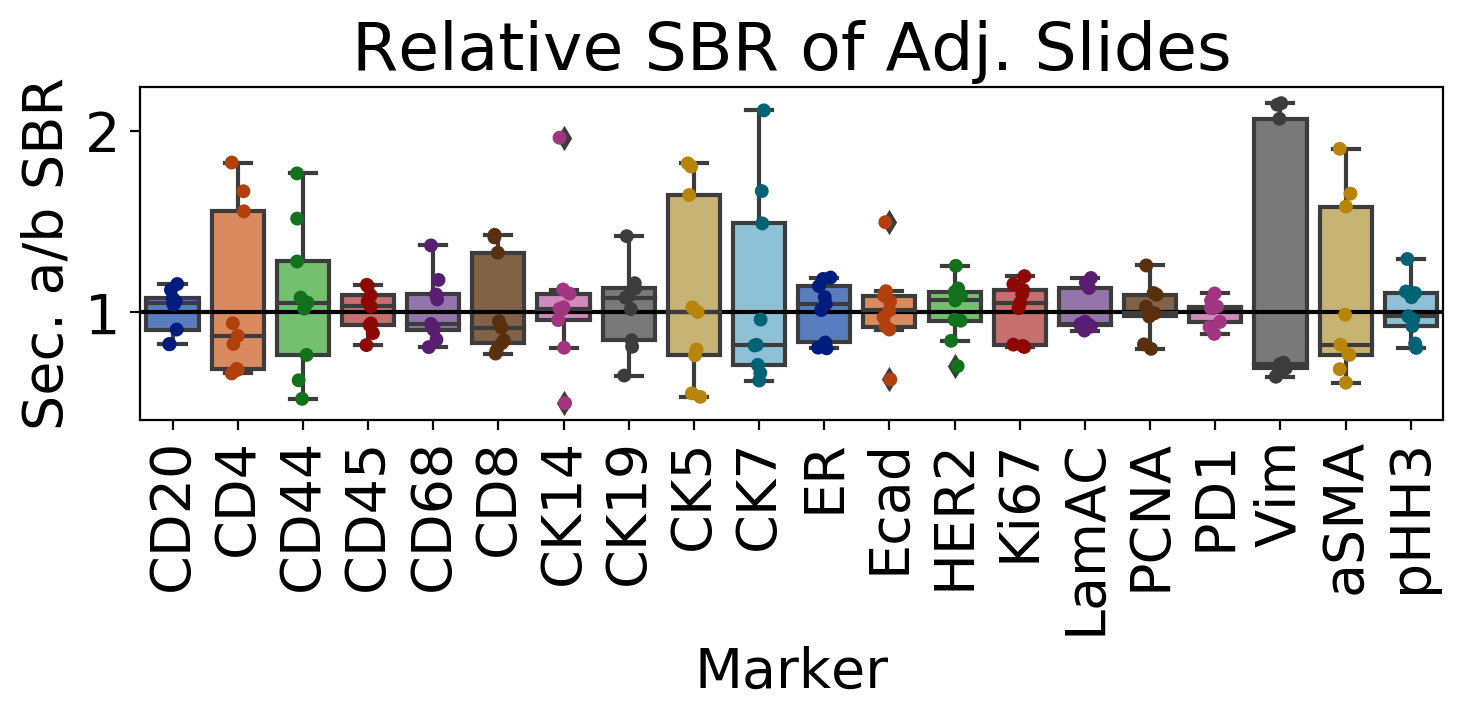

In [136]:
#zoomed in plot
s_title = "Relative SBR of Adj. Slides"
s_ylabel = "Sec. a/b SBR"

s_figname =f'{codedir}/Figures/BM-Her2N75/SNR_Ratio_JennyReps_zoomed_boxplot.png'
fig, ax = plt.subplots(figsize=(8,4),dpi=200)
#df_plot = df_percent.sort_values('mean_ratio', ascending=False).loc[:,['mean_ratio','stand_dev']]
#df_plot.plot(kind='bar', yerr='stand_dev', ax=ax, title = s_title,legend=False)
sns.boxplot(data=df_longer, x='marker', y='value', palette = 'muted')
sns.stripplot(data=df_longer, x='marker', y='value', palette = 'dark')
ax.set_ylabel(s_ylabel)
#ax.set_ylim(0,4)
ax.set_xlabel("Marker")
ax.axhline(1,color='black')

labels=ax.get_xticklabels()
ax.set_xticklabels(labels, rotation=90)
ax.set_title(s_title)


plt.tight_layout()
fig.savefig(s_figname)

# Compare SBR btwn tissue

SBR = mean intensity above threshold/mean intensity below threshold

compare SBR of tissue 1 relative to 2, tissue2 to 3 and tissue3 to 1

(total n=9)

In [137]:
#gereate plotting dataframe
df_percent = pd.DataFrame()
df_15 = ((df_t[df_t.scene=='17']).groupby(['marker','slide']).SNR.mean()) #15 = 17
df_17 = ((df_t[df_t.scene=='49']).groupby(['marker','slide']).SNR.mean()) # 17 = 49
df_18 = ((df_t[df_t.scene=='59']).groupby(['marker','slide']).SNR.mean()) # 18 = 59

df1 = df_15.unstack()/df_17.unstack()
df2 = df_17.unstack()/df_18.unstack()
df3 = df_18.unstack()/df_15.unstack()

df_long = pd.DataFrame()
df_longer = pd.DataFrame()
df_long = df_long.append(df1)
df_long = df_long.append(df2)
df_long = df_long.append(df3)
for s_marker in df1.index:
    ls_app = df_long.loc[s_marker].unstack().values
    df_app = pd.DataFrame(ls_app,columns=['value'])
    df_app['marker'] = s_marker
    df_longer = df_longer.append(df_app)
#stats
print(df_long.mean(axis=1).mean())
print(df_long.mean(axis=1).std())

1.1180326026694394
0.6253734599894761


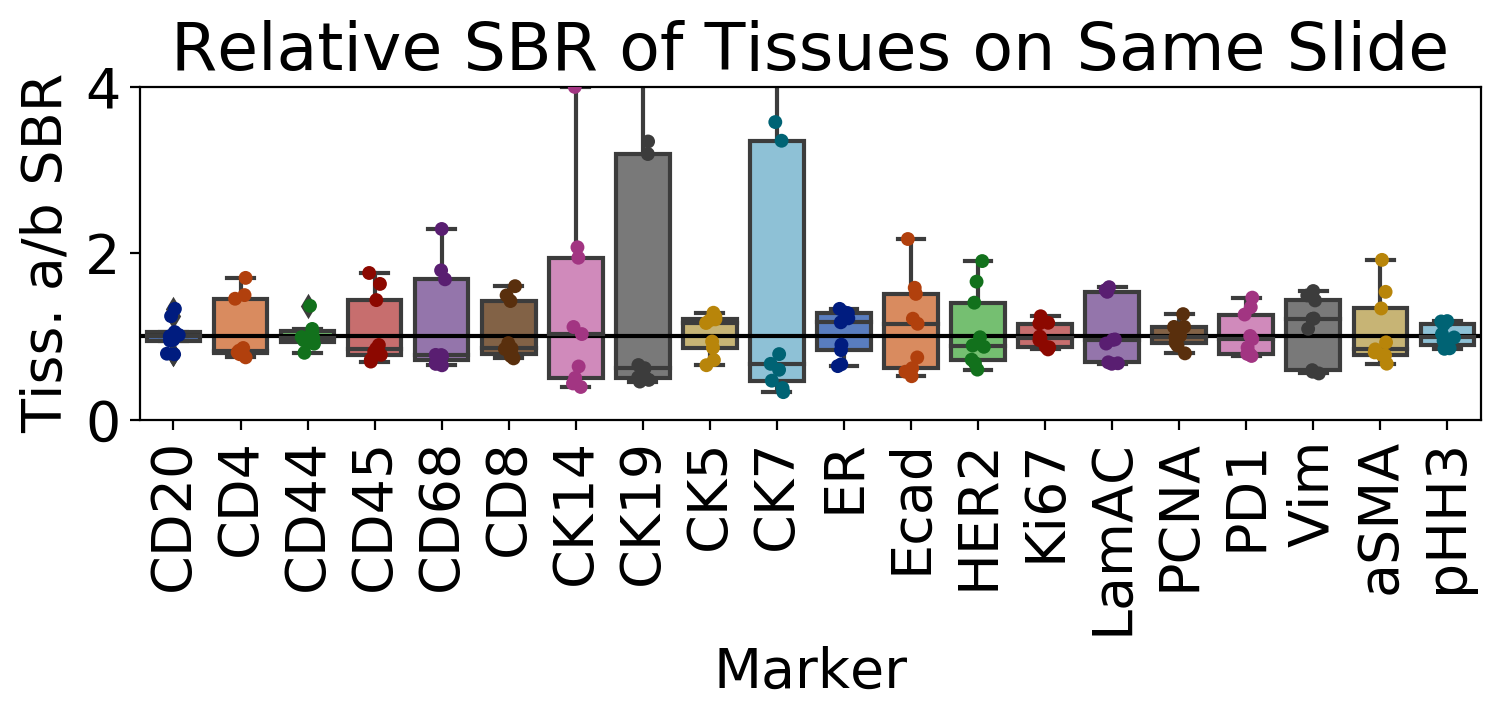

In [138]:
s_title = "Relative SBR of Tissues on Same Slide"
s_ylabel = "Tiss. a/b SBR"
s_figname =f'{codedir}/Figures/BM-Her2N75/Tissue_SNR_Ratio_JennyReps_boxplot.png'
fig, ax = plt.subplots(figsize=(8,4),dpi=200)
sns.boxplot(data=df_longer, x='marker', y='value', palette = 'muted')
sns.stripplot(data=df_longer, x='marker', y='value', palette = 'dark')
ax.set_ylabel(s_ylabel)
ax.set_ylim(0,4)
ax.set_xlabel("Marker")
ax.axhline(1,color='black')

labels=ax.get_xticklabels()
ax.set_xticklabels(labels, rotation=90)
ax.set_title(s_title)
plt.tight_layout()
fig.savefig(s_figname)
